In [1]:
%load_ext autoreload
%autoreload 2

import pennylane as qml
import math
from pennylane import qaoa
from pennylane import numpy as np
import matplotlib.pyplot as plt
from vqa.hamiltonian.protein_folding import protein_folding_hamiltonian
from vqa.hamiltonian.Protein_models.CoordinateBased_HPLattice import CoordinateBased_HPLattice
from vqa.utils.protein_utils import *
from collections import Counter
import pandas as pd
import csv
import os.path
import scipy
from scipy.optimize import minimize

In [2]:
# Make an instance for the protein
sequence = [1,0,0,1] #HPPH
L1 = 2
L2 = 2

lambda_vector = (2.1, 2.4, 3)

protein = CoordinateBased_HPLattice((L1, L2), sequence = sequence, lambda_vector = lambda_vector)
print(protein)
protein.calc_solution_sets()
feasible_set = np.array(protein.feasible_set)


O:
[-2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1]
T:
[[ 0.   4.2  0.   0.   2.4  0.  -1.  -1. ]
 [ 4.2  0.   0.   0.   0.   2.4 -1.  -1. ]
 [ 0.   0.   0.   4.2  0.   0.   2.4  0. ]
 [ 0.   0.   4.2  0.   0.   0.   0.   2.4]
 [ 2.4  0.   0.   0.   0.   4.2  0.   0. ]
 [ 0.   2.4  0.   0.   4.2  0.   0.   0. ]
 [-1.  -1.   2.4  0.   0.   0.   0.   4.2]
 [-1.  -1.   0.   2.4  0.   0.   4.2  0. ]]
Dn:
[2, 2, 2, 2]


In [3]:
# Make into Hamiltonian
H_cost = protein_folding_hamiltonian(protein)
num_qubits = protein.num_bits
qubits = range(protein.num_bits)

H_mixer = qaoa.x_mixer(qubits)

In [122]:
dev = qml.device('default.qubit', wires = qubits)

# Put the Mixer and Cost Hamiltonians in a layer so that we can repeat it
def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, H_cost)
    qaoa.mixer_layer(beta, H_mixer)
    
# Then repeat it in a circuit with starting in a super position of all bitstrings
def circuit(params): # Gamma and Beta values can be put together to be an array of parameters
    for q in qubits:     # To start in a superposition we place a Hadamard on all qubits
        qml.Hadamard(wires = q)
    qml.layer(qaoa_layer, len(params[0]), params[0], params[1])
    
# Obtains the probability for all the states
@qml.qnode(dev)
def get_probs(params):
    circuit(params)
    return qml.probs(wires = qubits)

def CVaRsamp(params, alpha=0.1, n=100):#n=antal samples
    circuit(params)
    
    probs = get_probs(params)  # hämta sannolikhetsfördelningen (matris, första värdet är p(00000000), andra är p(00000001) osv)
    
    index_samples= np.random.choice(np.arange(len(probs), dtype=int), size=n, replace=True,p=probs)  # tar n samples av probs, ger skum lista med index motsvarande konfiguration (index 0 är tillståndet 00000000, index 1 =00000001 osv)
    energy_of_samples=energies_of_set(protein.get_solution_set(), H_cost,8) [index_samples]  #ger en lista där index i index_samples är utbytta mot deras motsvarande energi. 
    sorted_energy_samples=sort_over_threshhold(energy_of_samples,-10)[0] #sorterar hela energilistan
    K=int(alpha*n) #antal samples att ta väntevärde över. 
    summa=sum(sorted_energy_samples[:K]) #summera de K minsta energierna.
    expvalue=np.float64(summa/K)
    
    return expvalue

In [130]:
def cost_execution(params):
    params = np.reshape(params, (2, 2))

    global iterations

    cost = CVaRsamp(params, n=num_of_samples)

    #if iterations % 50 == 0:
    print("Cost at Step {}: {}".format(iterations, cost))
    
    params_list.append(params)

    iterations += 1
    return cost

In [137]:
iterations = 0
p=2
counter = 0
j=0
num_of_samples=1000

params_list = []

initial_params=np.array([[0.1, 0.1], [0.5, 0.5]], requires_grad = True)
print(initial_params.shape)
out = minimize(cost_execution, x0=initial_params, method="COBYLA", options={"maxiter": 100}, tol=0.00001)
out_params = out["x"]
out_params = np.transpose(out_params)
print(out["x"])
print(out["success"])
probs = get_probs(out_params)

ground_energy, ground_states_i = get_ground_states_i(feasible_set, H_cost) # get the ground states

prob_list = []
for i in range(len(params_list)):
    p = get_probs(params_list[i])
    prob_list.append(float(np.sum(p[ground_states_i])))


#if np.sum(probs[ground_states_i]) < 0.05:
counter+=1
print('Try ' + str(j) + ': Success probability of training: ', np.sum(probs[ground_states_i]))
print('For: ' + str(num_of_samples) + ' samples, the prob of measuring any groundstate was at least 5% : ' + str(j-counter) + ' times out of ' + str(j) + ' tries.')
print("="*20)

(2, 2)
Cost at Step 0: -2.149000000000003


/tmp/ipykernel_13786/2452491054.py:11: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  out = minimize(cost_execution, x0=initial_params, method="COBYLA", options={"maxiter": 100}, tol=0.00001)


Cost at Step 1: -4.027999999999995
Cost at Step 2: -5.814000000000009
Cost at Step 3: -3.467999999999997
Cost at Step 4: -4.684999999999998
Cost at Step 5: -4.466999999999998
Cost at Step 6: -4.888999999999996
Cost at Step 7: -4.746999999999993
Cost at Step 8: -5.619000000000007
Cost at Step 9: -4.912999999999998
Cost at Step 10: -4.182999999999996
Cost at Step 11: -5.532000000000004
Cost at Step 12: -5.466000000000003
Cost at Step 13: -5.493000000000003
Cost at Step 14: -5.907000000000012
Cost at Step 15: -5.391
Cost at Step 16: -5.685000000000009
Cost at Step 17: -5.499000000000004
Cost at Step 18: -5.583000000000006
Cost at Step 19: -5.607000000000006
Cost at Step 20: -5.451000000000002
Cost at Step 21: -5.334
Cost at Step 22: -5.8140000000000125
Cost at Step 23: -5.637000000000008
Cost at Step 24: -5.7600000000000104
Cost at Step 25: -5.6340000000000074
Cost at Step 26: -5.517000000000004
Cost at Step 27: -5.535000000000004
Cost at Step 28: -5.574000000000005
Cost at Step 29: -5.55

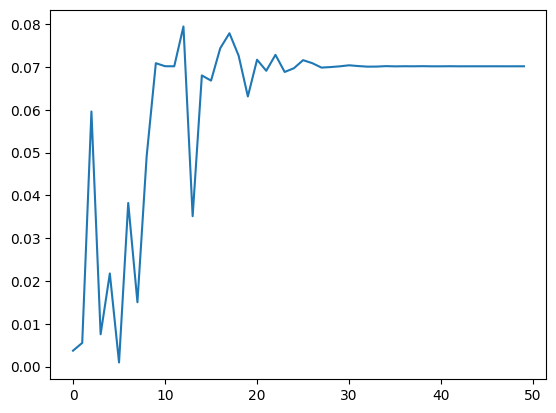

In [136]:
plt.plot(prob_list)
plt.show()